Run a quick simulation to view the A matrix

System size: (400, 400)
Grid: 20 x 10 = 200 nodes
State vector size: 400
Source at grid point: (10, 1)


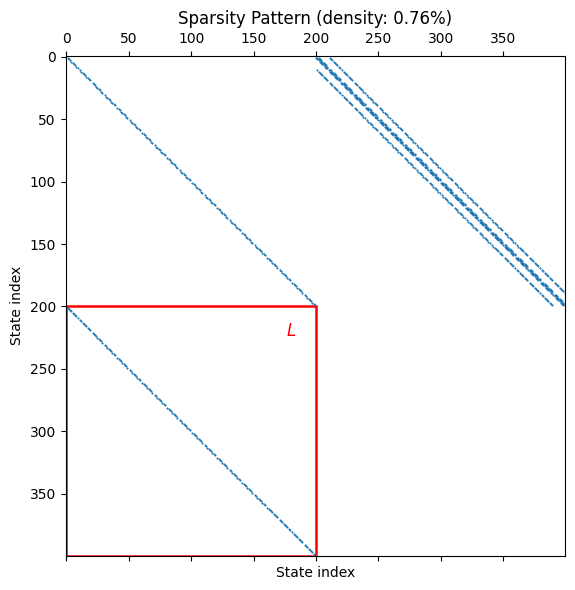

cond₂(A) = inf
A dtype: float64
Max decimal digits for float64: 15 so can work with at most ~-inf digits of precision


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from getParam_Sonar import getParam_Sonar
from matplotlib.patches import Rectangle

Nx, Nz = 20, 10 
Lx, Lz = 200, 100 

p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)

A = p['A']
B = p['B']
N = Nx * Nz

print(f"System size: {A.shape}")
print(f"Grid: {Nx} x {Nz} = {N} nodes")
print(f"State vector size: {2*N}")
print(f"Source at grid point: ({p['sonar_ix']}, {p['sonar_iz']})")

# Visualize sparsity pattern
fig, ax = plt.subplots(figsize=(6, 6))

ax.spy(A, markersize=0.5)
ax.set_title(f'Sparsity Pattern (density: {np.count_nonzero(A)/A.size:.2%})')
ax.set_xlabel('State index')
ax.set_ylabel('State index')

# Outline the L block (bottom-left N x N)
ax.add_patch(Rectangle((0, N), N, N, fill=False, edgecolor='red', linewidth=1.8))

# Label it
ax.text(N*.9, N*1.1, r'$L$', color='red', ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 2-norm condition number: κ₂(A) = σ_max / σ_min
kappa2_A = np.linalg.cond(A)             
print(f"cond₂(A) = {kappa2_A:.3e}")
print(f"A dtype: {A.dtype}")
print(f"Max decimal digits for {A.dtype}: {np.finfo(A.dtype).precision} so can work with at most ~{np.finfo(A.dtype).precision - np.log10(kappa2_A):.0f} digits of precision")


# What you see:
#   d[p]/dt = [0   I ][p] + [0]u
#    [v]      [L  -aI][v]   [b]

Next, run provided SimpleSolver. We don't expect stable behavior, since Forward Euler is non-ideal for wave propagation.

In [22]:
from eval_f_Sonar import eval_f_Sonar
from eval_u_Sonar import eval_u_Sonar_20, eval_u_Sonar_20_const
from SimpleSolver import SimpleSolver

Nx, Nz = 100, 50    # Nx, Nz = 20, 20  
Lx, Lz = 10e3, 1e3   # Lx, Lz = 50, 50  

p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)

eval_u = eval_u_Sonar_20 # eval_u_Sonar_20_const
# Scale u(t) by cell area so Bu remains grid-invariant with b=1/(dx*dz)
def eval_u_scaled(t):
    return (p['dx']*p['dz']) * eval_u(t)
eval_f = eval_f_Sonar

visualize = False
w = max_dt_FE * 0.1
num_iter = int(np.ceil((t_stop - t_start) / w)) 

print(f"Number of iterations: {num_iter}")

[X, t] = SimpleSolver(eval_f, x_start, p, eval_u, num_iter, w, visualize, gif_file_name="test_SimpleSolver_Sonar.gif")

Number of iterations: 13860
started running a simple solver, please wait...


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Sonar Simulation Domain Setup'}, xlabel='X Distance (m)', ylabel='Z Depth (m)'>)

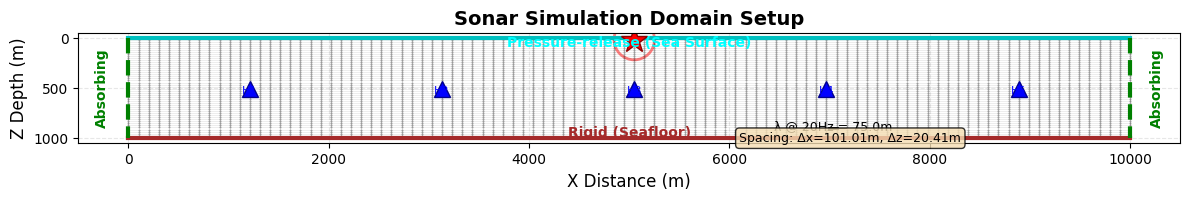

In [23]:
from visualize_sonar import visualize_sonar_setup

visualize_sonar_setup(p, show_grid=True, show_boundary_labels=True)

# hydrophone

Processing hydrophone data...


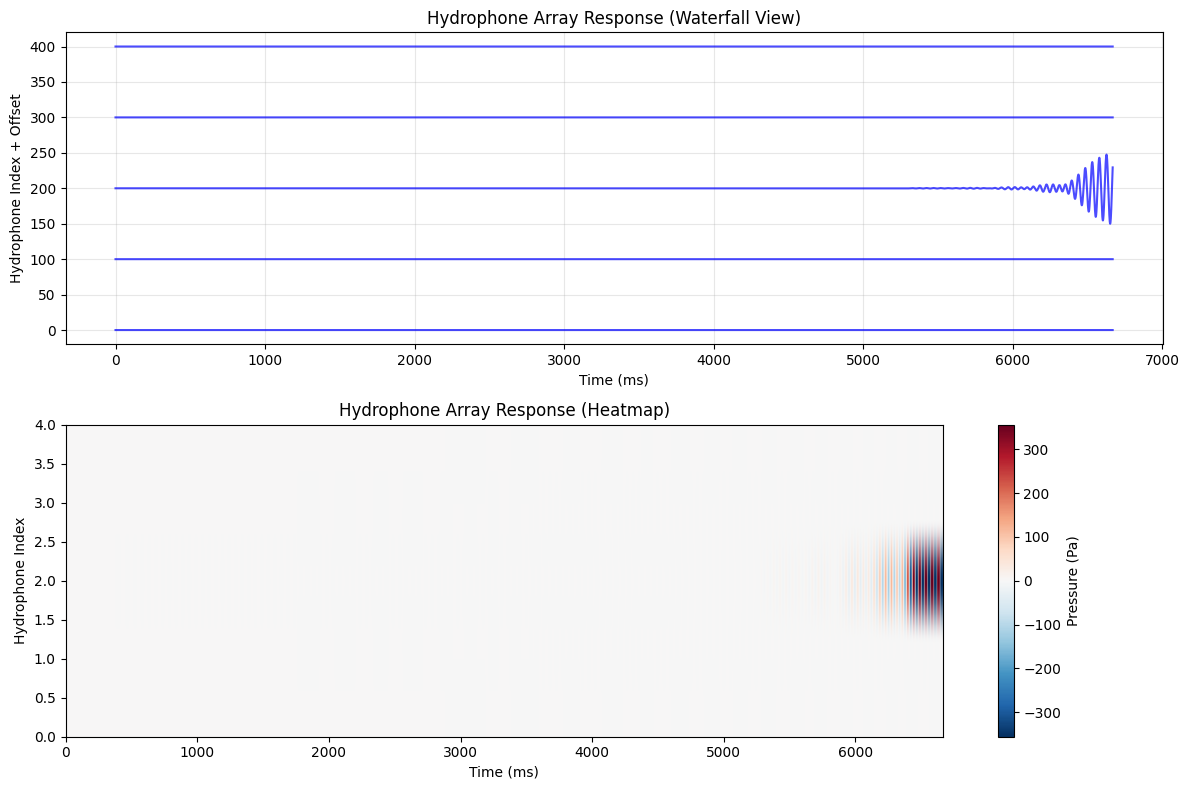

In [24]:
from eval_g_Sonar import eval_g_Sonar

# extract hydrophone outputs over time
print("Processing hydrophone data...")
num_phones = len(p['hydrophones']['x_indices'])
hydrophone_history = np.zeros((num_phones, len(t)))

for i in range(len(t)):
    y = eval_g_Sonar(X[:, i], p)
    hydrophone_history[:, i] = y.flatten()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

adjust_view = 1e7 #1e9
# Auto-scale waveform display so traces are visible relative to offsets
amp = float(np.nanmax(np.abs(hydrophone_history)) + 1e-12)
adjust_view = 50.0 / amp
# Auto-scale waveform display so traces are visible relative to offsets
amp = float(np.nanmax(np.abs(hydrophone_history)) + 1e-12)
adjust_view = 50.0 / amp

# waterfall plot 
for i in range(num_phones):
    x_pos = p['hydrophones']['x_indices'][i] * p['dx']
    ax1.plot(t*1000, adjust_view*hydrophone_history[i, :] + i*100, 'b-', alpha=0.7)
    
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Hydrophone Index + Offset')
ax1.set_title('Hydrophone Array Response (Waterfall View)')
ax1.grid(True, alpha=0.3)

# heatmap 
vmax = float(np.quantile(np.abs(hydrophone_history), 0.995) + 1e-12)
vmin = -vmax
im = ax2.imshow(hydrophone_history, aspect='auto', origin='lower',
                extent=[t[0]*1000, t[-1]*1000, 0, num_phones-1],
                cmap='RdBu_r')
im.set_clim(vmin=vmin, vmax=vmax)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Hydrophone Index')
ax2.set_title('Hydrophone Array Response (Heatmap)')
plt.colorbar(im, ax=ax2, label='Pressure (Pa)')

plt.tight_layout()
plt.show()

In [25]:
from simpleLeapFrog import *

X, t = LeapfrogSolver(eval_f, x_start, p, eval_u_scaled, num_iter, dt=w, visualize=False)

Running Leapfrog solver (stable for wave equations)...
Bootstrapping with RK4 for first step...
Running 13859 leapfrog steps...
  Progress: 10.0%
  Progress: 20.0%
  Progress: 30.0%
  Progress: 40.0%
  Progress: 50.0%
  Progress: 60.0%
  Progress: 70.0%
  Progress: 80.0%
  Progress: 90.0%
Leapfrog integration complete!


Processing hydrophone data...


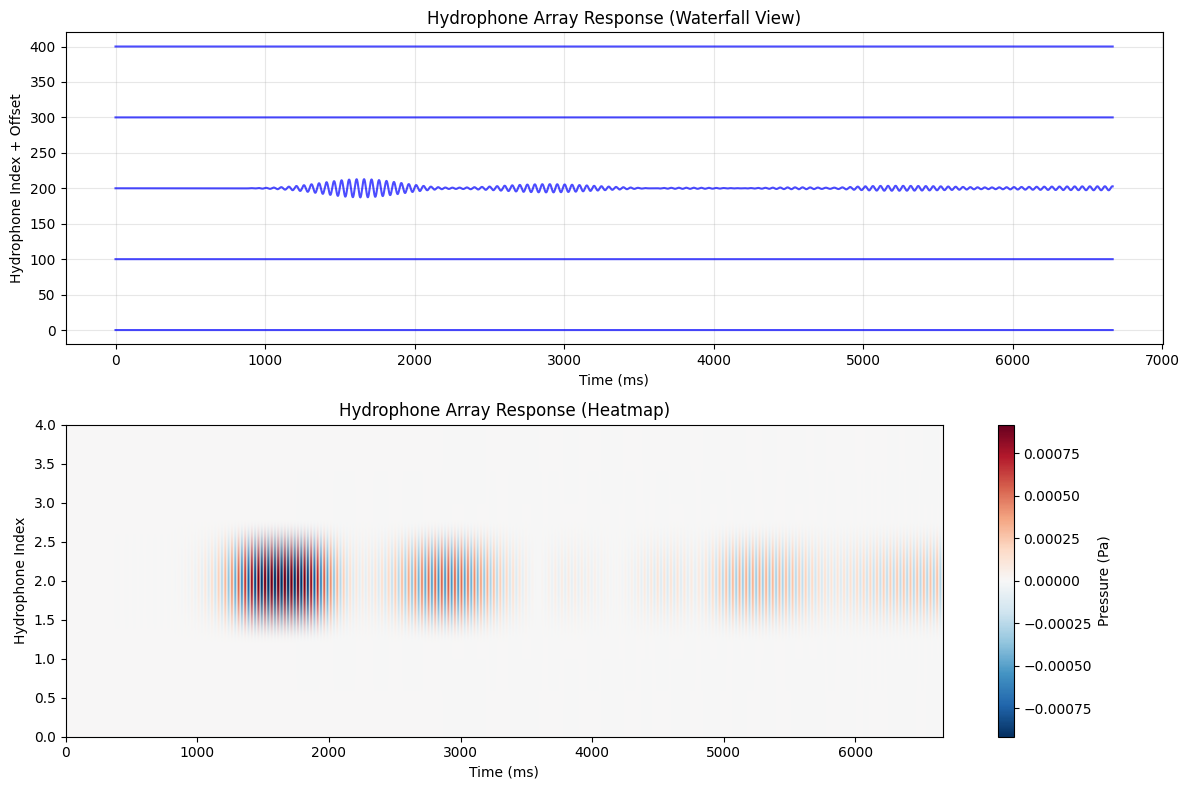

In [26]:
from eval_g_Sonar import eval_g_Sonar

# extract hydrophone outputs over time
print("Processing hydrophone data...")
num_phones = len(p['hydrophones']['x_indices'])
hydrophone_history = np.zeros((num_phones, len(t)))

for i in range(len(t)):
    y = eval_g_Sonar(X[:, i], p)
    hydrophone_history[:, i] = y.flatten()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

adjust_view = 1e4 #1e9

# waterfall plot 
for i in range(num_phones):
    x_pos = p['hydrophones']['x_indices'][i] * p['dx']
    ax1.plot(t*1000, adjust_view*hydrophone_history[i, :] + i*100, 'b-', alpha=0.7)
    
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Hydrophone Index + Offset')
ax1.set_title('Hydrophone Array Response (Waterfall View)')
ax1.grid(True, alpha=0.3)

# heatmap 
vmax = float(np.quantile(np.abs(hydrophone_history), 0.995) + 1e-12)
vmin = -vmax
im = ax2.imshow(hydrophone_history, aspect='auto', origin='lower',
                extent=[t[0]*1000, t[-1]*1000, 0, num_phones-1],
                cmap='RdBu_r')
im.set_clim(vmin=vmin, vmax=vmax)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Hydrophone Index')
ax2.set_title('Hydrophone Array Response (Heatmap)')
plt.colorbar(im, ax=ax2, label='Pressure (Pa)')

plt.tight_layout()
plt.show()


SOLVER STABILITY COMPARISON

1. Testing SimpleSolver (Forward Euler)...
started running a simple solver, please wait...

2. Testing LeapfrogSolver...
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with RK4 for first step...
Running 20787 leapfrog steps...
  Progress: 10.0%
  Progress: 20.0%
  Progress: 30.0%
  Progress: 40.0%
  Progress: 50.0%
  Progress: 60.0%
  Progress: 70.0%
  Progress: 80.0%
  Progress: 90.0%
  Progress: 100.0%
Leapfrog integration complete!

RESULTS:
Forward Euler - Final energy ratio: 1.05e+34
Leapfrog      - Final energy ratio: 7.11e-02
⚠️  Forward Euler is UNSTABLE (growing energy)


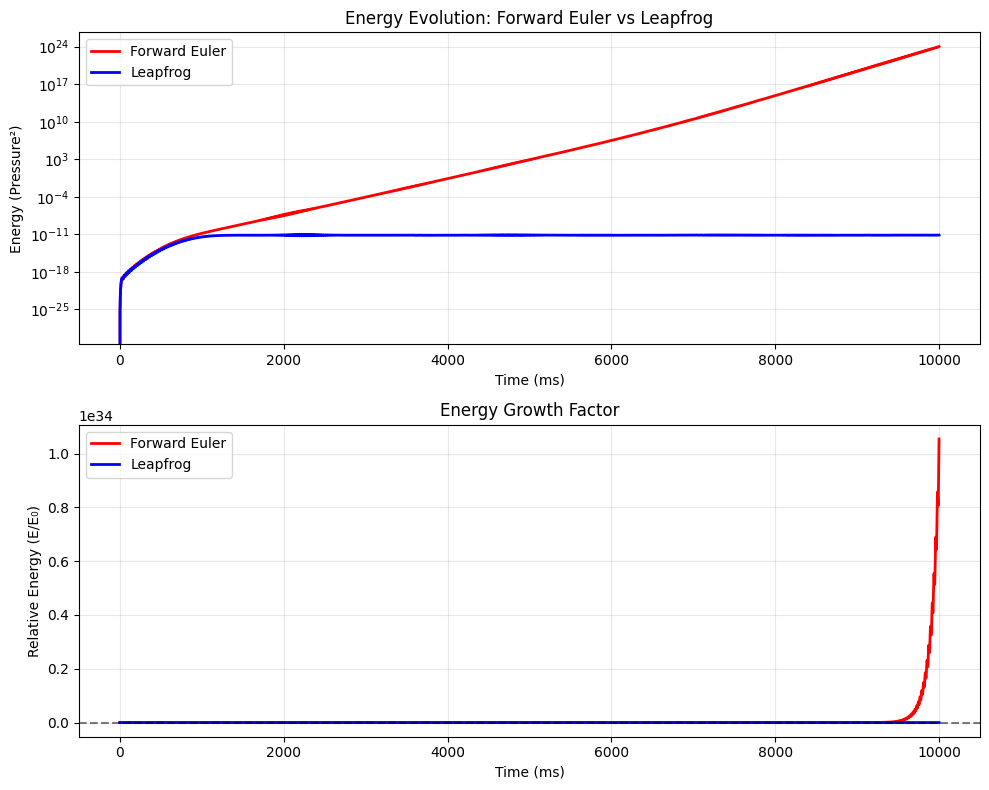

In [18]:
# Compare solvers
fig = test_solver_stability(p, eval_f, eval_u, x_start, max_dt_FE)
plt.show()

Implement our own suite of tests

COMPLETE SONAR MODEL TEST SUITE

PART A: MODEL FUNCTIONALITY TESTS

TEST 1: Matrix Dimensions
----------------------------------------
✓ PASSED: Matrix dimensions correct

TEST 2: Zero Input Response
----------------------------------------
✓ PASSED: Zero state remains stable

TEST 3: Source Excitation
----------------------------------------
✓ PASSED: Source generates signal: -7.51e-18 Pa

TEST 4: CFL Condition
----------------------------------------
✓ PASSED: Timestep 0.001241 respects CFL

TEST 5: Hydrophone Configuration
----------------------------------------
✓ PASSED: 5 hydrophones configured

TEST 6: Short-term Stability
----------------------------------------
started running a simple solver, please wait...
✓ PASSED: No immediate divergence

PART B: JACOBIAN TEST BENCH

TEST 7: Linear System Check
----------------------------------------
✓ PASSED: Jacobian equals A matrix (linear system)

TEST 8: Finite Difference Verification
----------------------------------------
  dx = 1

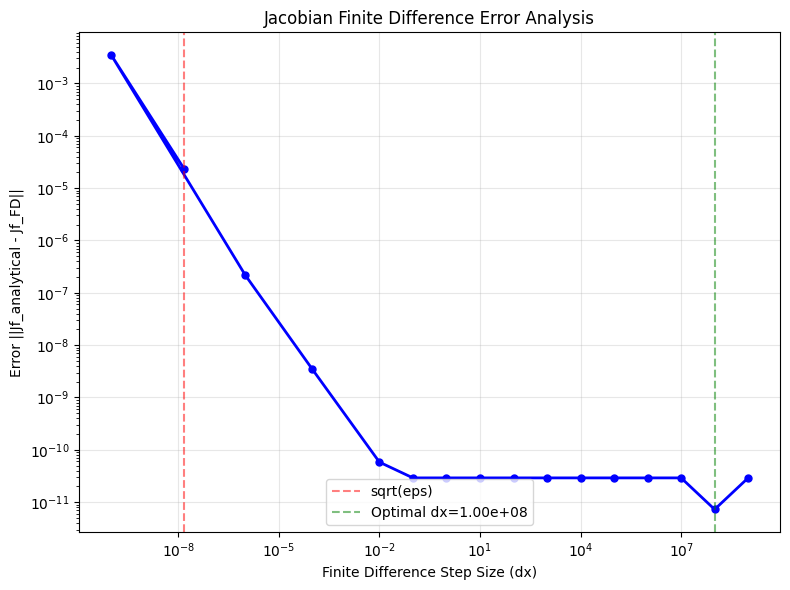


COMPLETE TEST SUMMARY
Total Tests Passed: 10
Total Tests Failed: 0
Overall Success Rate: 100.0%

✓ ALL TESTS PASSED!


(10, 0)

In [19]:
from test_Sonar import test_sonar_complete

test_sonar_complete(eval_u)

# finite differences Jacobian is sitting right around machine precision
# our system is indeed linear! no truncation error

In [20]:
# Test dt sweep for leapfrog
fig = test_dt_sweep_leapfrog(eval_f_Sonar, x_start, p, eval_u,
                             exponents=range(-9, -13, -1),
                             max_steps=100,
                             use_outputs=True,
                             quiet=False)
plt.show()

[sweep] Coarsest Δt=1.0e-09 -> T=1.000e-07 with max_steps=100
[run] Δt_target=1.0e-09 → cold-restart chunks up to max_steps=100
Running Leapfrog solver (stable for wave equations)...
   [Δt=1.0e-09] chunk 1 done (steps=100, t=1.000e-07/1.000e-07)
[run] Δt_target=1.0e-10 → cold-restart chunks up to max_steps=100
Running Leapfrog solver (stable for wave equations)...
   [Δt=1.0e-10] chunk 1 done (steps=100, t=1.000e-08/1.000e-07)
Running Leapfrog solver (stable for wave equations)...
   [Δt=1.0e-10] chunk 2 done (steps=100, t=2.000e-08/1.000e-07)
Running Leapfrog solver (stable for wave equations)...
   [Δt=1.0e-10] chunk 3 done (steps=100, t=3.000e-08/1.000e-07)
Running Leapfrog solver (stable for wave equations)...
   [Δt=1.0e-10] chunk 4 done (steps=100, t=4.000e-08/1.000e-07)
Running Leapfrog solver (stable for wave equations)...
   [Δt=1.0e-10] chunk 5 done (steps=100, t=5.000e-08/1.000e-07)
Running Leapfrog solver (stable for wave equations)...
   [Δt=1.0e-10] chunk 6 done (steps=1

KeyboardInterrupt: 

# wave viz

In [ ]:
# Visualize pressure over XZ plane at a given time/index
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sonar_viz import plot_pressure_xz_at

# Interactive index slider if ipywidgets is available; fallback to last frame
try:
    import ipywidgets as widgets
    slider = widgets.IntSlider(value=int(len(np.asarray(t).reshape(-1)) - 1), min=0, max=int(X.shape[1] - 1), step=1, description='Index')
    ui = widgets.HBox([slider])
    out = widgets.interactive_output(lambda Index: plot_pressure_xz_at(p, X, t, index=Index), {'Index': slider})
    display(ui, out)
except Exception as e:
    print('Interactive widgets unavailable; plotting last step. Error:', e)
    plot_pressure_xz_at(p, X, t, index=int(X.shape[1] - 1))

Output()

Creating animation with 2772 frames (skip=5)...


KeyboardInterrupt: 

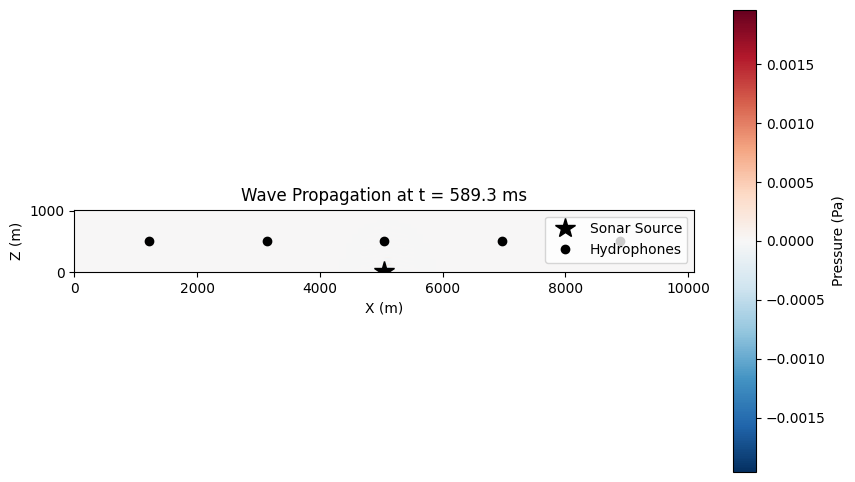

In [ ]:
import create_wave_animation as cwa
cwa.create_wave_animation(X, t, p, save_filename='wave_animation.gif')

Creating 3D animation with:
  - Total time steps: 13861
  - Frame skip: 10
  - Animation frames: 1386
  - Time span: 0.0 to 6667.0 ms
Saving 3D animation as wave_animation_3d.gif...
3D animation saved as wave_animation_3d.gif


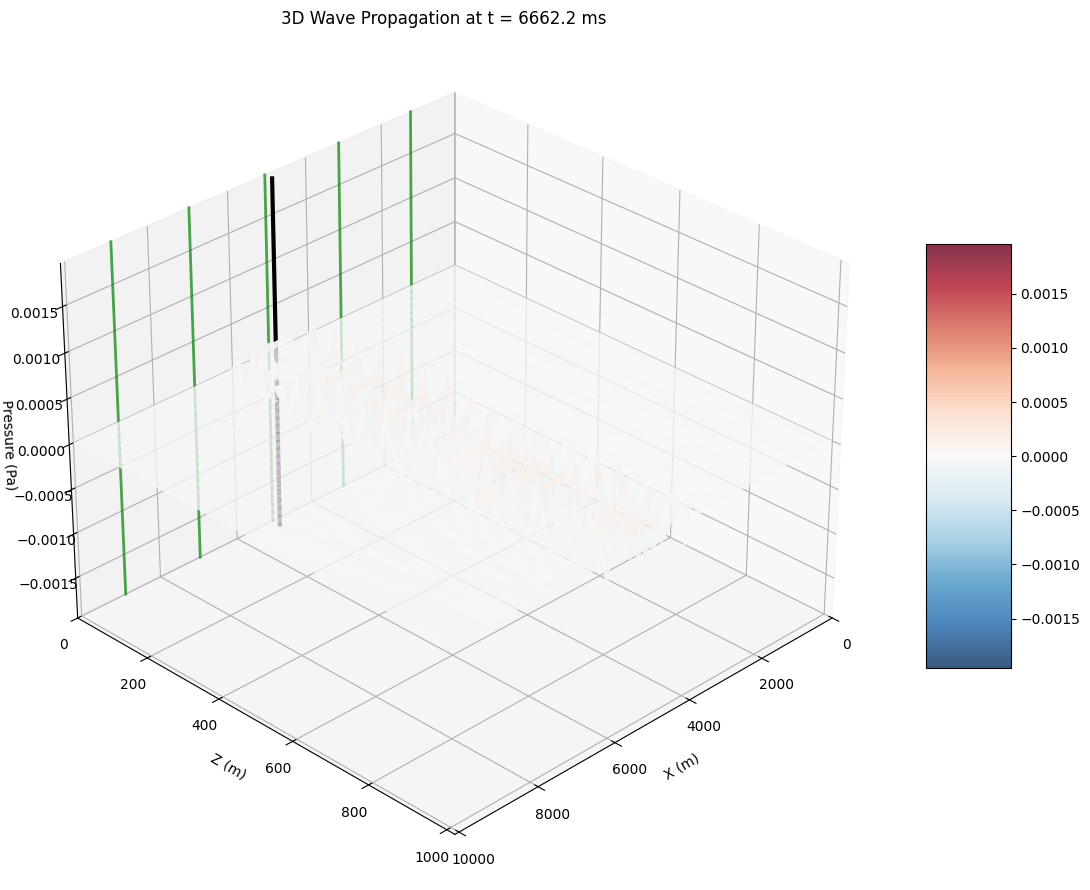

In [ ]:
import create_3d_wave_animation as cwa3d
cwa3d.create_3d_wave_animation(X, t, p, save_filename='wave_animation_3d.gif')